# TVB for Epilepsy


### Basic configurations

In [1]:
!source activate python2.7.3
!source activate python2_7

%matplotlib inline

import os
from copy import deepcopy

import sys

import numpy as np
stdout = sys.stdout
from tvb_epilepsy.base.constants.config import Config
from tvb_epilepsy.base.utils.log_error_utils import initialize_logger
from tvb_epilepsy.io.tvb_data_reader import TVBReader
from tvb_epilepsy.io.h5_reader import H5Reader
from tvb_epilepsy.io.h5_writer import H5Writer
from tvb_epilepsy.plot.plotter import Plotter

input_folder = os.path.join(os.path.expanduser("~"), 'Dropbox', 'Work', 'VBtech', 'VEP', "results", "CC", "TVB3", "tvb")
head_folder = os.path.join(os.path.expanduser("~"), 'Dropbox', 'Work', 'VBtech', 'VEP', "results", "CC", "TVB3", "Head")
output_folder = os.path.join(os.path.expanduser("~"), 'Dropbox', 'Work', 'VBtech', 'VEP', "results", "tests")
config = Config(head_folder=input_folder, output_base=output_folder, data_mode="tvb") #, data_mode="java"
config.hypothesis.head_folder = head_folder
config.figures.MATPLOTLIB_BACKEND="inline"
config.figures.SHOW_FLAG=True
logger = initialize_logger(__name__, config.out.FOLDER_LOGS)
reader = TVBReader() if config.input.IS_TVB_MODE else H5Reader()
writer = H5Writer()
plotter = Plotter(config)
sys.stdout = stdout


CondaEnvironmentNotFoundError: Could not find environment: python2_7 .
You can list all discoverable environments with `conda info --envs`.



### Read data from tvb or Head folder

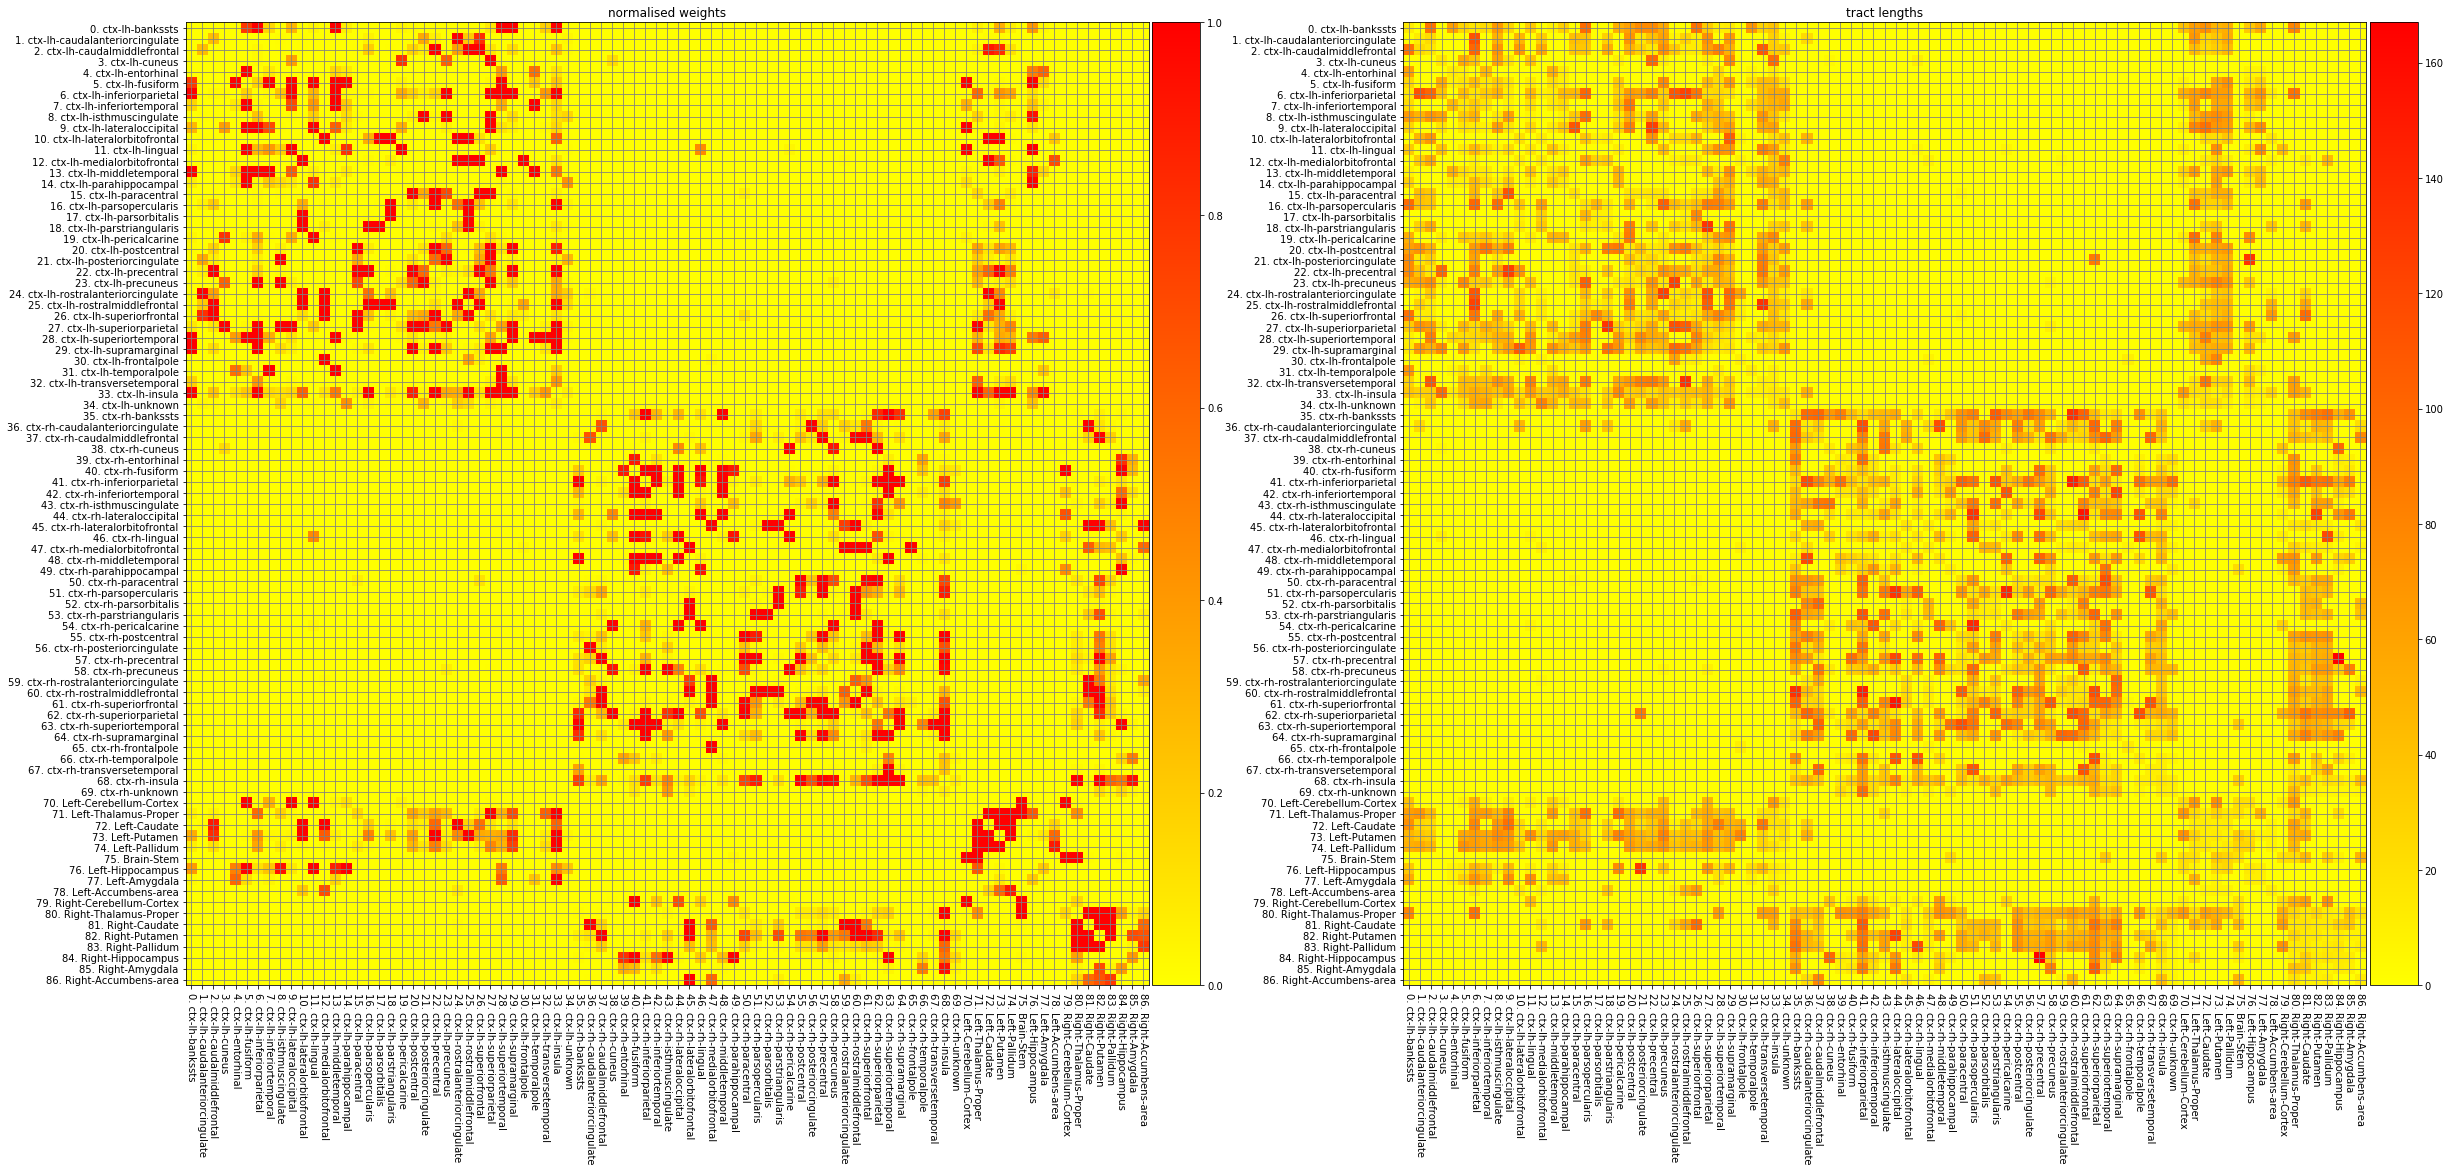

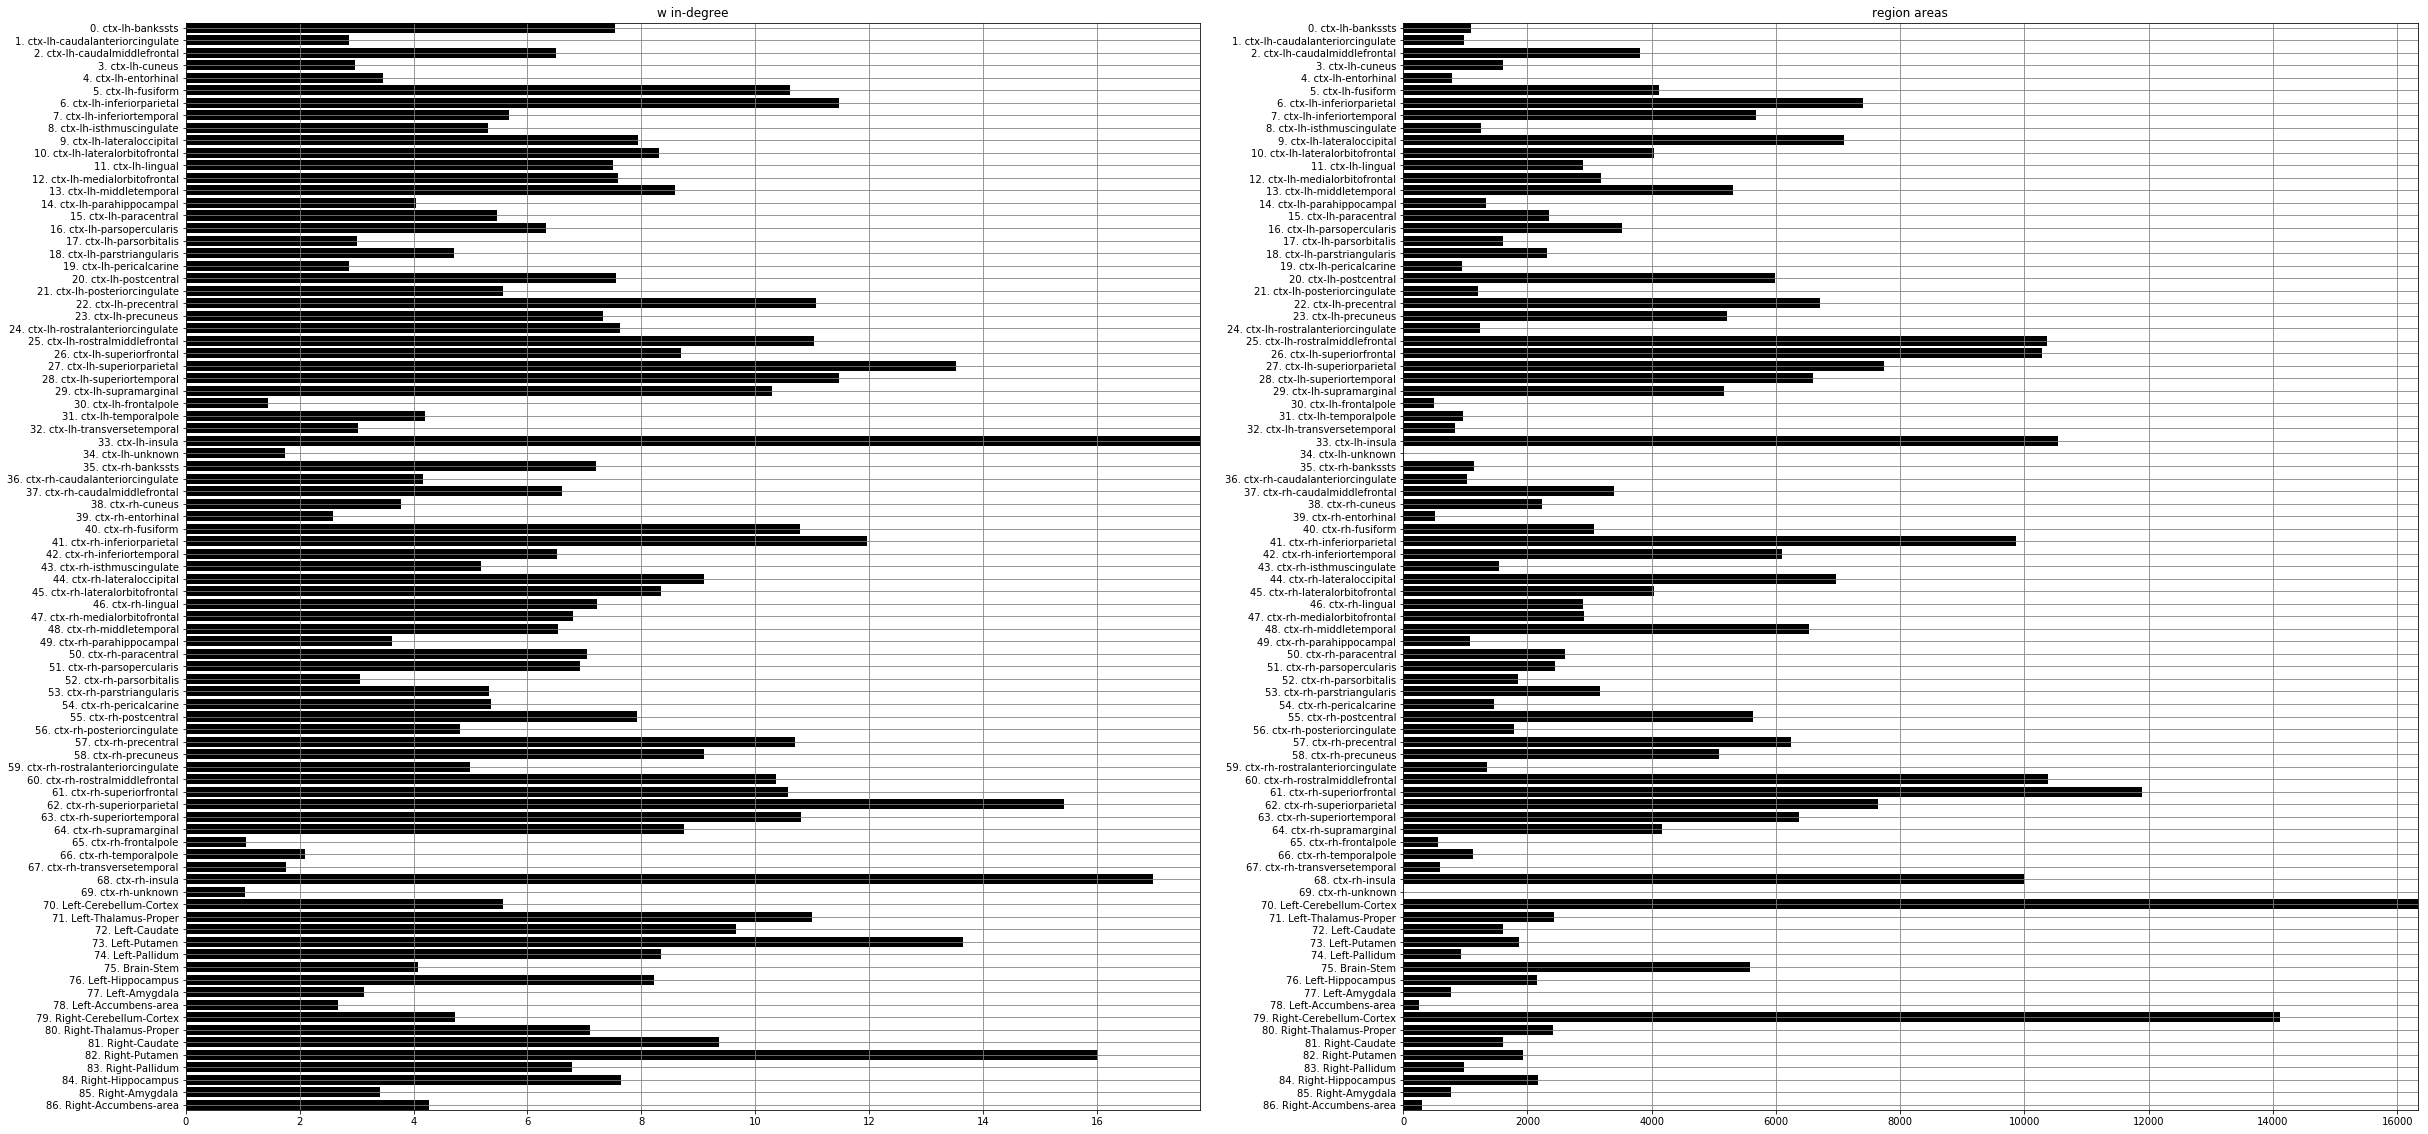

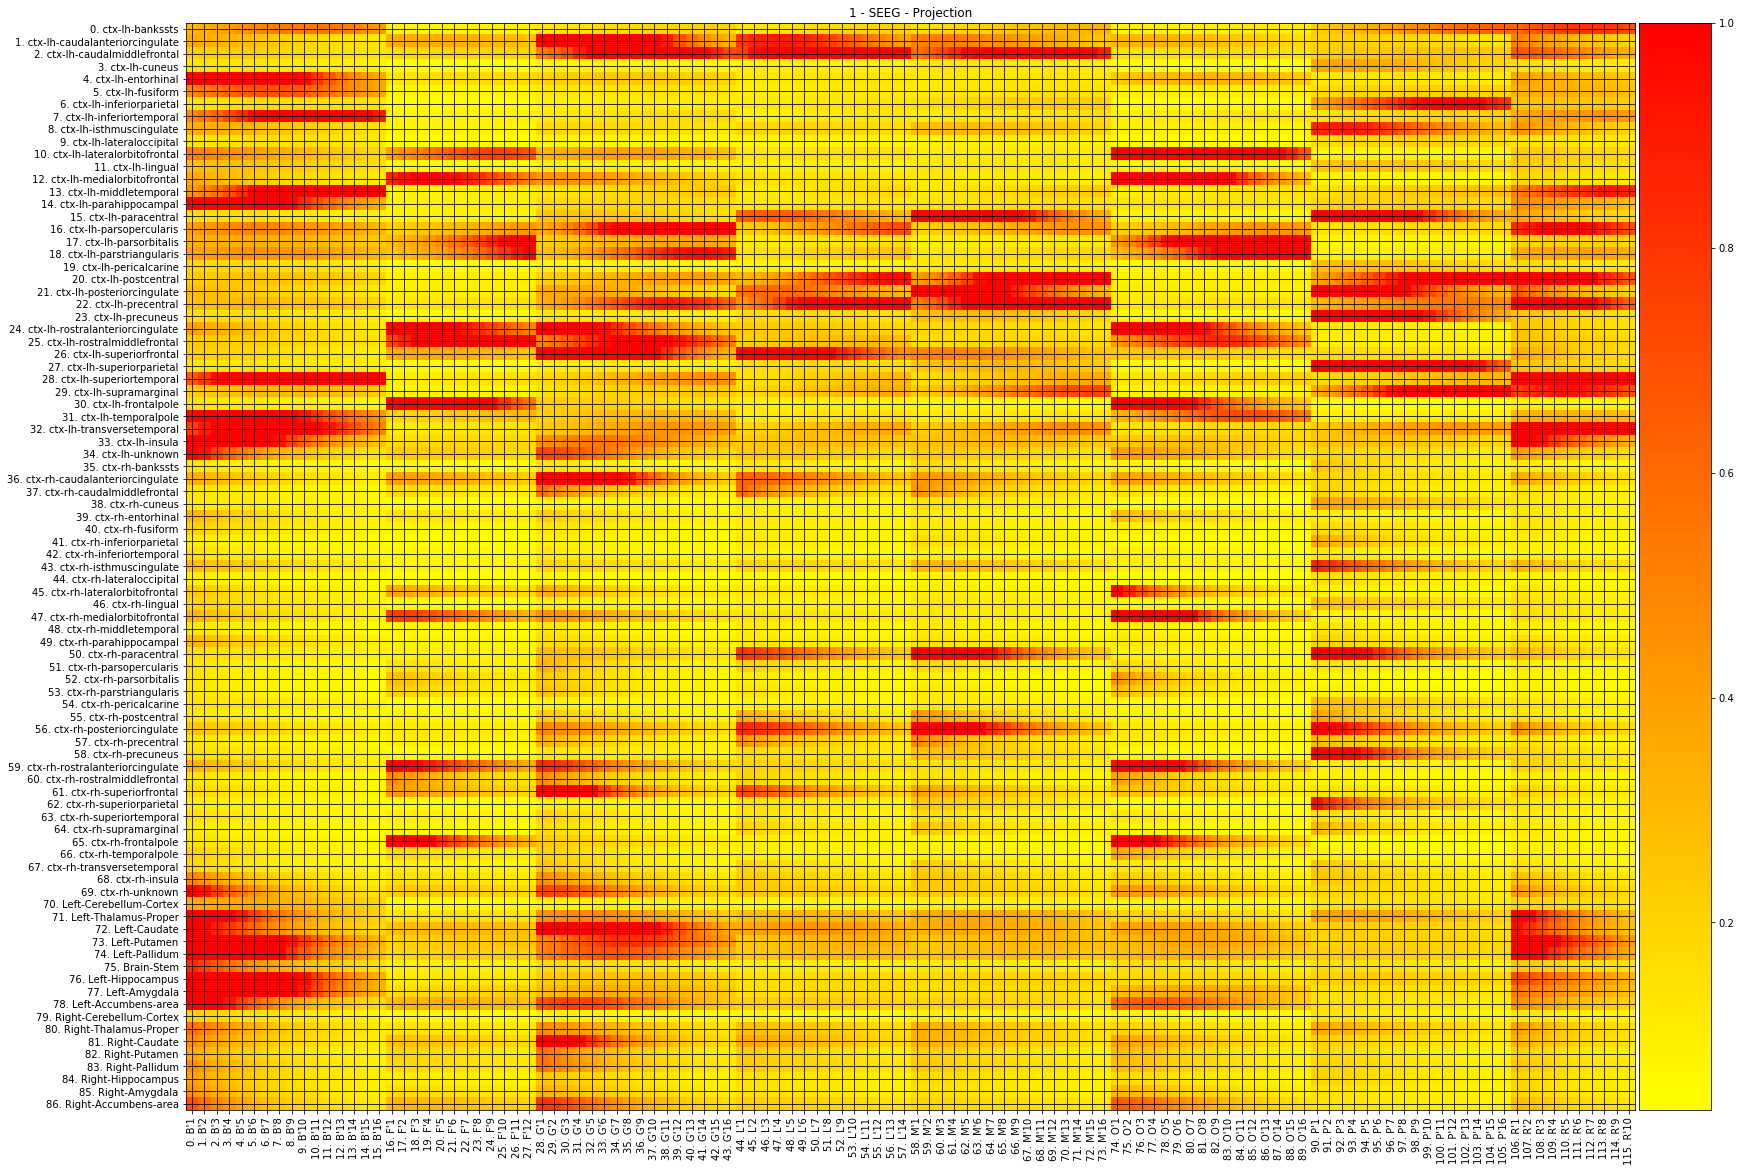

In [2]:
### Reading data
logger.info("Reading from: " + config.input.HEAD)
head = reader.read_head(config.input.HEAD, seeg_sensors_files=[("seeg_xyz.txt",)])
# Plot
plotter.plot_head(head)

### Generate an hypothesis...

In [3]:
from tvb_epilepsy.service.hypothesis_builder import HypothesisBuilder
# Read clinical hypothesis... 
hyp_builder = HypothesisBuilder(head.connectivity.number_of_regions, config).set_normalize(1.0)

 ### ...by reading from epileptogenicity file

In [4]:
e_indices = [1, 26]# [1, 2, 25, 26]
hypothesis = hyp_builder.build_hypothesis_from_file("clinical_hypothesis_postseeg", e_indices)        

### ...or by manual definition 

In [ ]:
#...of formulate a VEP hypothesis manually
from tvb_epilepsy.service.hypothesis_builder import HypothesisBuilder

hyp_builder = HypothesisBuilder(head.connectivity.number_of_regions, config).set_normalize(0.95)

# Regions of Pathological Excitability hypothesis:
x0_indices = []
x0_values = []

# Regions of Model Epileptogenicity hypothesis:
e_indices = []
e_values = []

# Regions of Connectivity hypothesis:
w_indices = [] # [(0, 1), (0, 2)] 
w_values = [] # [0.5, 2.0] 
# hypo_builder.set_w_indices(w_indices).set_w_values(w_values)

hypothesis = hyp_builder.set_x0_hypothesis(x0_indices, x0_values).set_x0_hypothesis(e_indices, e_values).set_w_hypothesis(w_indices, w_values).build_hypothesis()

### Print hypothesis

In [5]:
disease_indices = hypothesis.get_regions_disease_indices()
disease_values = hypothesis.get_regions_disease_values()
w_indices = hypothesis.get_connectivity_disease_indices()
w_values = hypothesis.get_connectivity_disease_values()
n_w = len(w_indices)
n_e = len(e_indices)
n_disease = len(disease_indices)
n_x0 = n_disease - n_e
all_regions_indices = np.array(range(head.number_of_regions))
healthy_indices = np.delete(all_regions_indices, disease_indices).tolist()
n_healthy = len(healthy_indices)
print(hypothesis)
print(hypothesis.string_regions_disease(head.connectivity.region_labels))
print(hypothesis.string_connectivity_disease(head.connectivity.region_labels))

DiseaseHypothesis{
01. Name = e_x0_Hypothesis
02. Type = Excitability_Epileptogenicity
03. Number of regions = 87
04. Excitability (x0) disease indices = [2, 25]
05. Excitability (x0) disease values = [ 0.34850544  0.35292119]
06. Epileptogenicity (E) disease indices = [1, 26]
07. Epileptogenicity (E) disease indices = [ 0.99716938  1.        ]
08. Connectivity (W) disease indices = []
09. Connectivity (W) disease values = []
10. Propagation indices = []
11. Propagation strengths of indices = []}
1. ctx-lh-caudalanteriorcingulate: E=0.99716937542
2. ctx-lh-caudalmiddlefrontal: x0=0.348505437374
25. ctx-lh-rostralmiddlefrontal: x0=0.352921187878
26. ctx-lh-superiorfrontal: E=1.0



### Generate model configuration from hypothesis



File /Users/dionperd/Dropbox/Work/VBtech/VEP/results/tests/res/e_x0_Hypothesis_model_config_service.h5 already exists. Enter a different name or press enter to overwrite file: 
1: E=0.99716937542
2: x0=0.00999999977648
25: x0=0.00999999977648
26: E=0.992500007153
K = 5.74713
x0_max = 0.606406106789


File /Users/dionperd/Dropbox/Work/VBtech/VEP/results/tests/res/e_x0_Hypothesis_ModelConfig.h5 already exists. Enter a different name or press enter to overwrite file: 


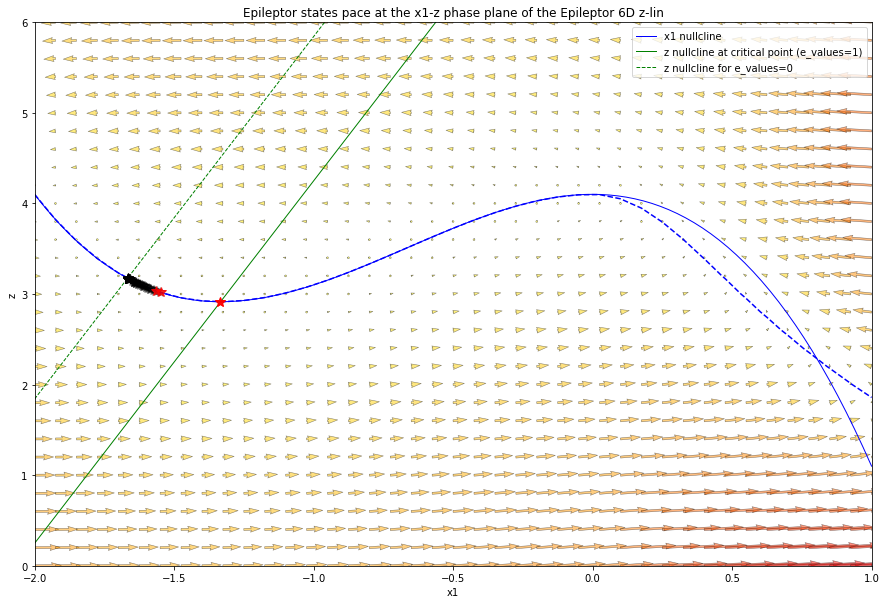

In [22]:
from tvb_epilepsy.service.model_configuration_builder import ModelConfigurationBuilder
from tvb_epilepsy.base.constants.model_constants import K_DEF

logger.info("\n\nRunning hypothesis: " + hypothesis.name)
logger.info("\n\nCreating model configuration...")
K = 10*K_DEF
model_config_builder = ModelConfigurationBuilder(hypothesis.number_of_regions, K=K)
mcs_file = os.path.join(config.out.FOLDER_RES, hypothesis.name + "_model_config_service.h5")
writer.write_model_configuration_builder(model_config_builder, mcs_file)
hypothesis.x0_values[0] = 0.01
hypothesis.x0_values[1] = 0.01
hypothesis.e_values[1] = 0.9925
print(hypothesis.string_regions_disease())
# Assume all healthy nodes have x0_values = 0.0:
model_configuration = model_config_builder.build_model_from_hypothesis(hypothesis, head.connectivity.normalized_weights)
# # Assume all healthy nodes have e_values = 0.0
# model_configuration = model_config_builder.build_model_from_E_hypothesis(hypothesis, head.connectivity.normalized_weights)
print "K =", np.mean(model_configuration.K)
print "x0_max =", np.max(model_configuration.x0)
mc_path = os.path.join(config.out.FOLDER_RES, hypothesis.name + "_ModelConfig.h5")
writer.write_model_configuration(model_configuration, mc_path)
# Plot nullclines and equilibria of model configuration
plotter.plot_state_space(model_configuration, "6D", head.connectivity.region_labels, 
                         special_idx=hypothesis.x0_indices + hypothesis.e_indices, 
                         figure_name=hypothesis.name + "_StateSpace")

### Run linear stability analysis

2018-02-23 14:33:02,948 - WARNING - tvb_epilepsy.service.lsa_service - Equilibria x1EQ[[1]]  = [-1.3342768]
were corrected for LSA to value: X1_EQ_CR_DEF - 10 ** (-3) = -1.33433333333 to be sub-critical!
DiseaseHypothesis{
01. Name = LSA_e_x0_Hypothesis
02. Type = Excitability_Epileptogenicity
03. Number of regions = 87
04. Excitability (x0) disease indices = [2, 25]
05. Excitability (x0) disease values = [ 0.00283062  0.00283062]
06. Epileptogenicity (E) disease indices = [1, 26]
07. Epileptogenicity (E) disease indices = [ 0.99        0.98533063]
08. Connectivity (W) disease indices = []
09. Connectivity (W) disease values = []
10. Propagation indices = [24 26  1]
11. Propagation strengths of indices = [ 0.41403823  0.51072646  1.49492079]}


File /Users/dionperd/Dropbox/Work/VBtech/VEP/results/tests/res/LSA_e_x0_Hypothesis_LSA.h5 already exists. Enter a different name or press enter to overwrite file: 


File /Users/dionperd/Dropbox/Work/VBtech/VEP/results/tests/res/LSA_e_x0_Hypothe

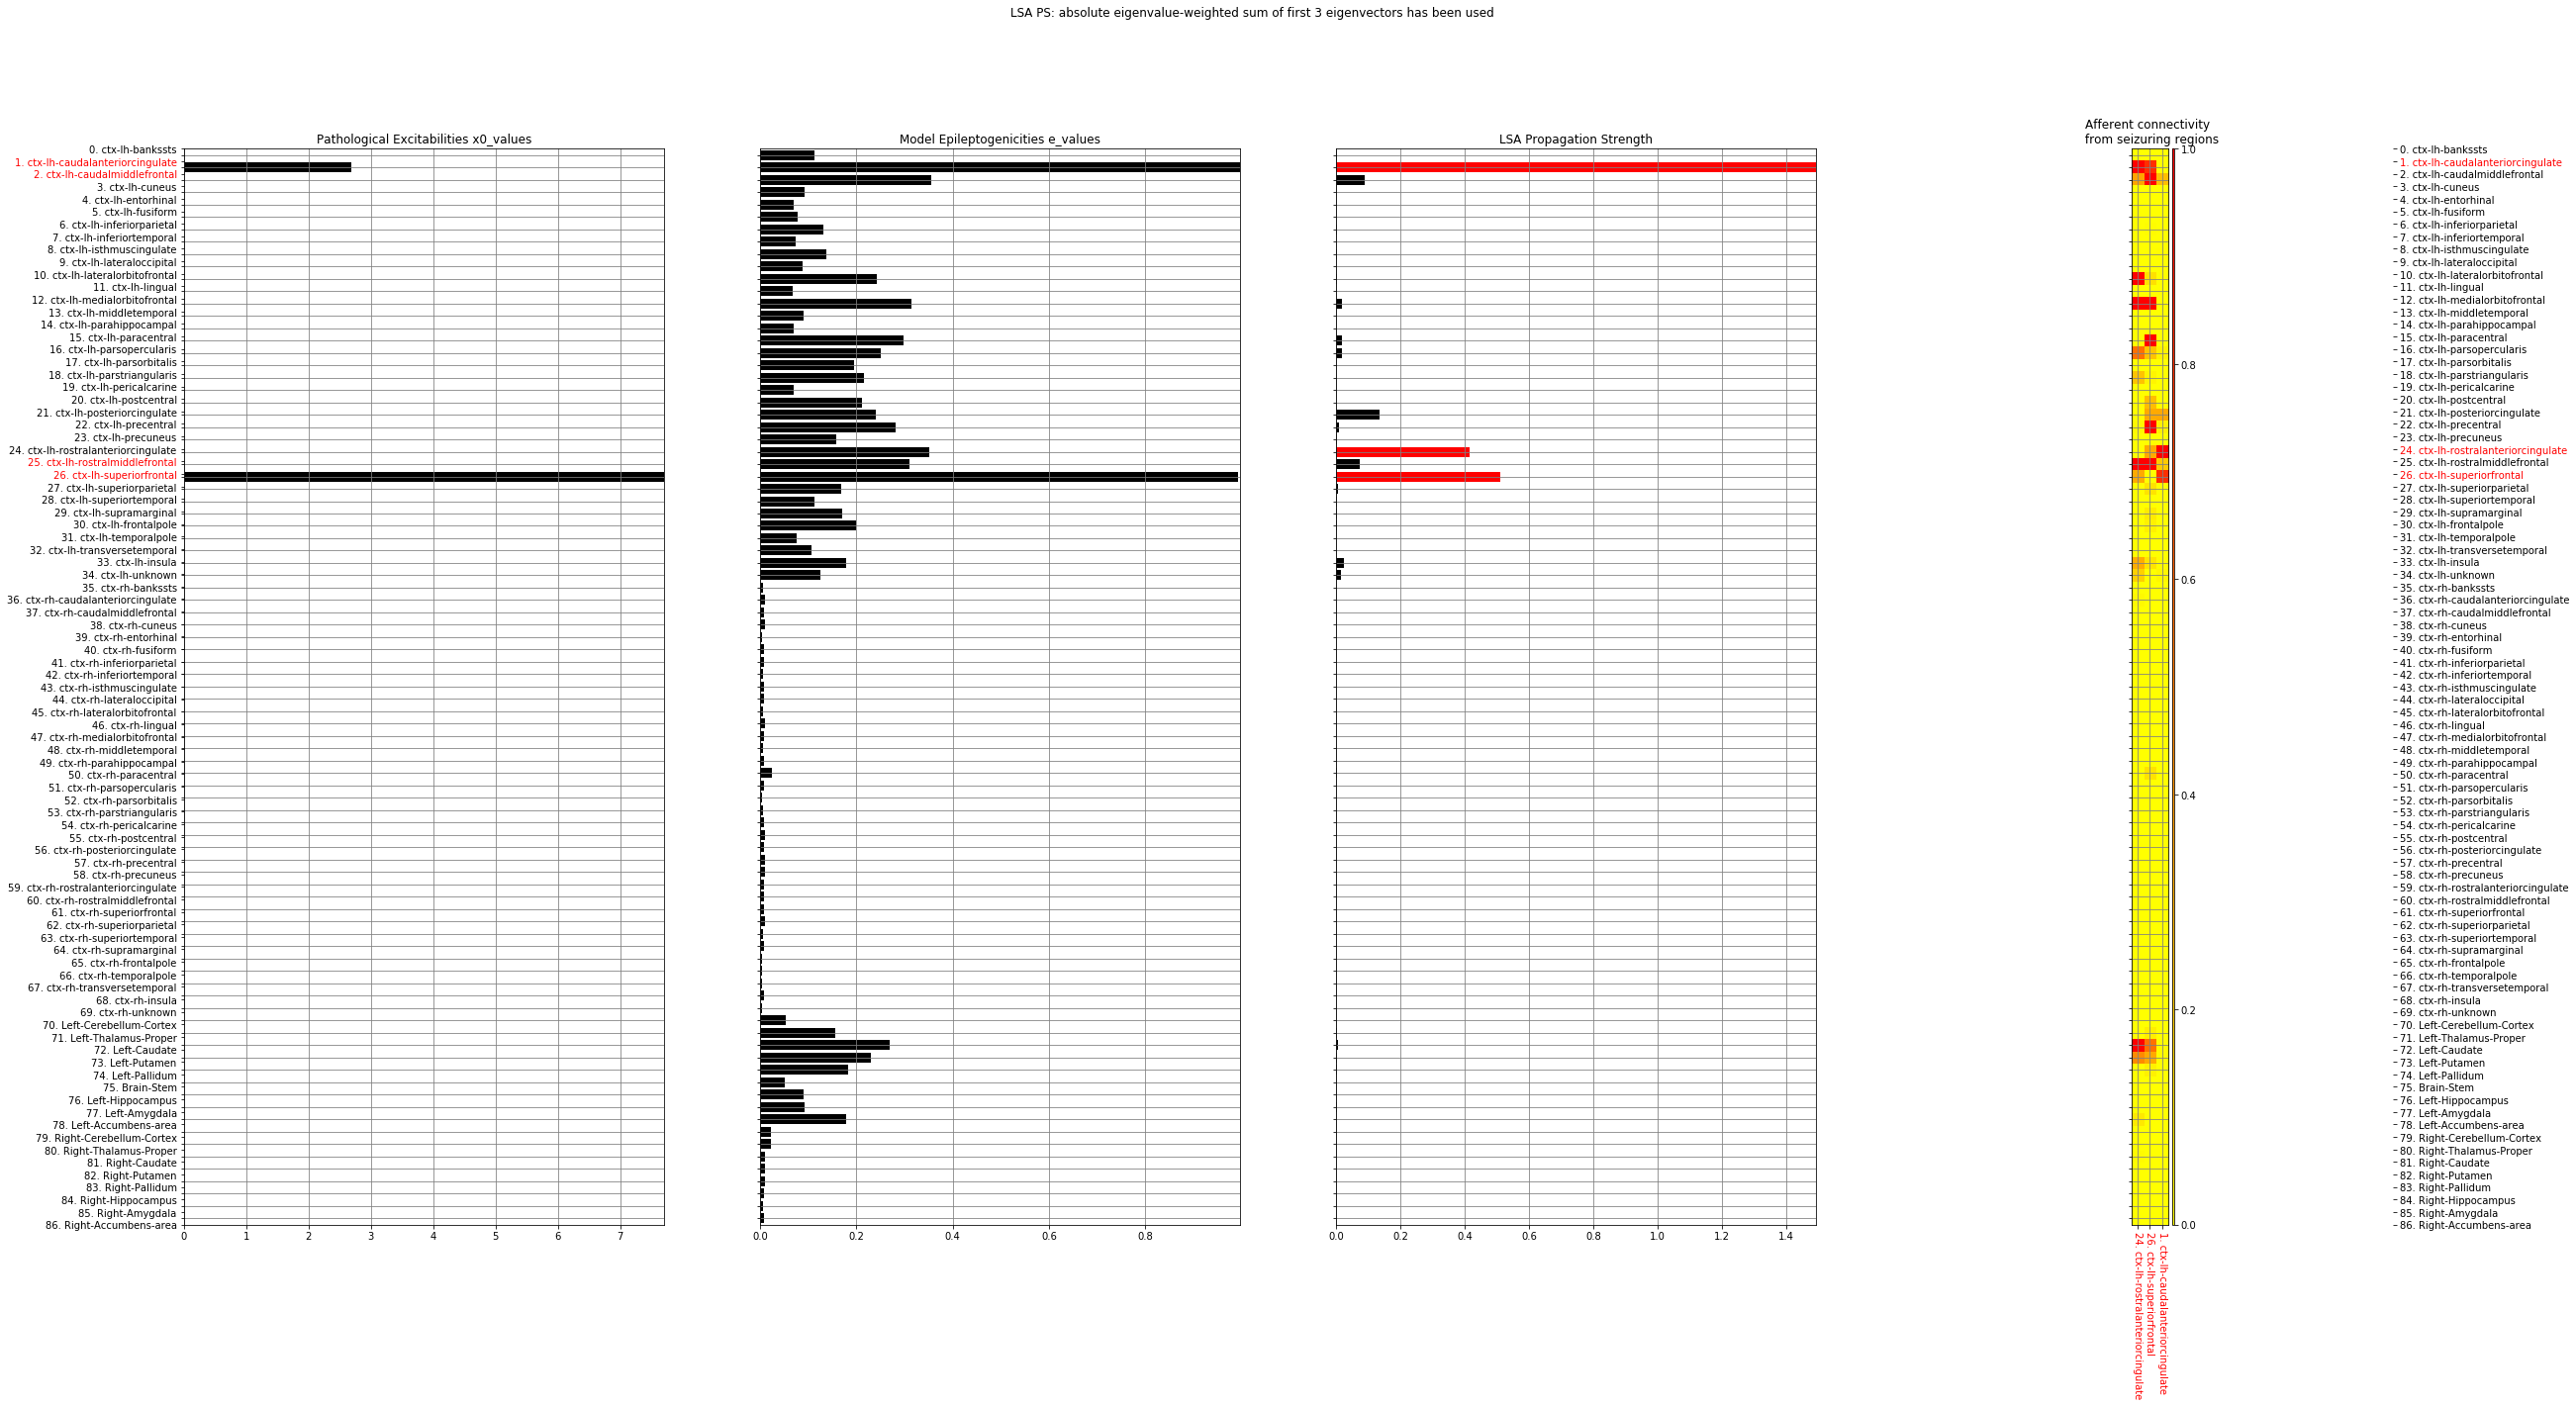

In [23]:
# Run linear stability analysis
from tvb_epilepsy.service.lsa_service import LSAService
logger.info("\n\nRunning LSA...")
# Options for eigen_vectors_number: 
# "auto_eigenvals": eigenvalues curve elbow point selection,
# "auto_disease": len(n_disease), 
# "auto_epileptogenicity": Model Epileptogenicity curve elbow point selection,
# "auto_excitability": Pathological Excitability curve elbow point selection
# or "user_defined": a number equal to from 1 to hypothesis.number_of_regions
lsa_service = LSAService(eigen_vectors_number=None, 
                         eigen_vectors_number_selection="auto_eigenvals", 
                         weighted_eigenvector_sum=True, 
                         normalize_propagation_strength=False)
lsa_hypothesis = lsa_service.run_lsa(hypothesis, model_configuration)
print(lsa_hypothesis)
lsa_path = os.path.join(config.out.FOLDER_RES, lsa_hypothesis.name + "_LSA.h5")
lsa_config_path = os.path.join(config.out.FOLDER_RES, lsa_hypothesis.name + "_LSAConfig.h5")
writer.write_hypothesis(lsa_hypothesis, lsa_path)
writer.write_lsa_service(lsa_service, lsa_config_path)

# Plot
plotter.plot_lsa(lsa_hypothesis, model_configuration, lsa_service.weighted_eigenvector_sum,
                 lsa_service.eigen_vectors_number, head.connectivity.region_labels, None);


### Run parameter search exploration for linear stability analysis around the clinical hypothesis

In [ ]:
from tvb_epilepsy.top.scripts.pse_scripts import pse_from_lsa_hypothesis
# --------------Parameter Search Exploration (PSE)-------------------------------
logger.info("\n\nRunning PSE LSA...")
n_samples = 100
pse_results = pse_from_lsa_hypothesis(lsa_hypothesis,
                                      head.connectivity.normalized_weights,
                                      head.connectivity.region_labels,
                                      n_samples, param_range=0.1,
                                      global_coupling=[{"indices": all_regions_indices}],
                                      healthy_regions_parameters=[
                                                        {"name": "x0_values", "indices": healthy_indices}],
                                      model_configuration_builder=builder,
                                      lsa_service=lsa_service, logger=logger, save_flag=True)[0]
plotter.plot_lsa(lsa_hypothesis, model_configuration, lsa_service.weighted_eigenvector_sum,
                lsa_service.eigen_vectors_number, head.connectivity.region_labels, pse_results)

pse_lsa_path = os.path.join(config.out.FOLDER_RES, lsa_hypothesis.name + "_PSE_LSA_results.h5")
writer.write_dictionary(pse_results, pse_lsa_path)

### Simulation


('noise_intesity=', 1e-07)


File /Users/dionperd/Dropbox/Work/VBtech/VEP/results/tests/res/LSA_e_x0_Hypothesis_sim_settings.h5 already exists. Enter a different name or press enter to overwrite file: 


File /Users/dionperd/Dropbox/Work/VBtech/VEP/results/tests/res/LSA_e_x0_Hypothesis_sim_model.h5 already exists. Enter a different name or press enter to overwrite file: 
...100.0% done in 29.8079819679 secs

File /Users/dionperd/Dropbox/Work/VBtech/VEP/results/tests/res/LSA_e_x0_Hypothesis_ts.h5 already exists. Enter a different name or press enter to overwrite file: 


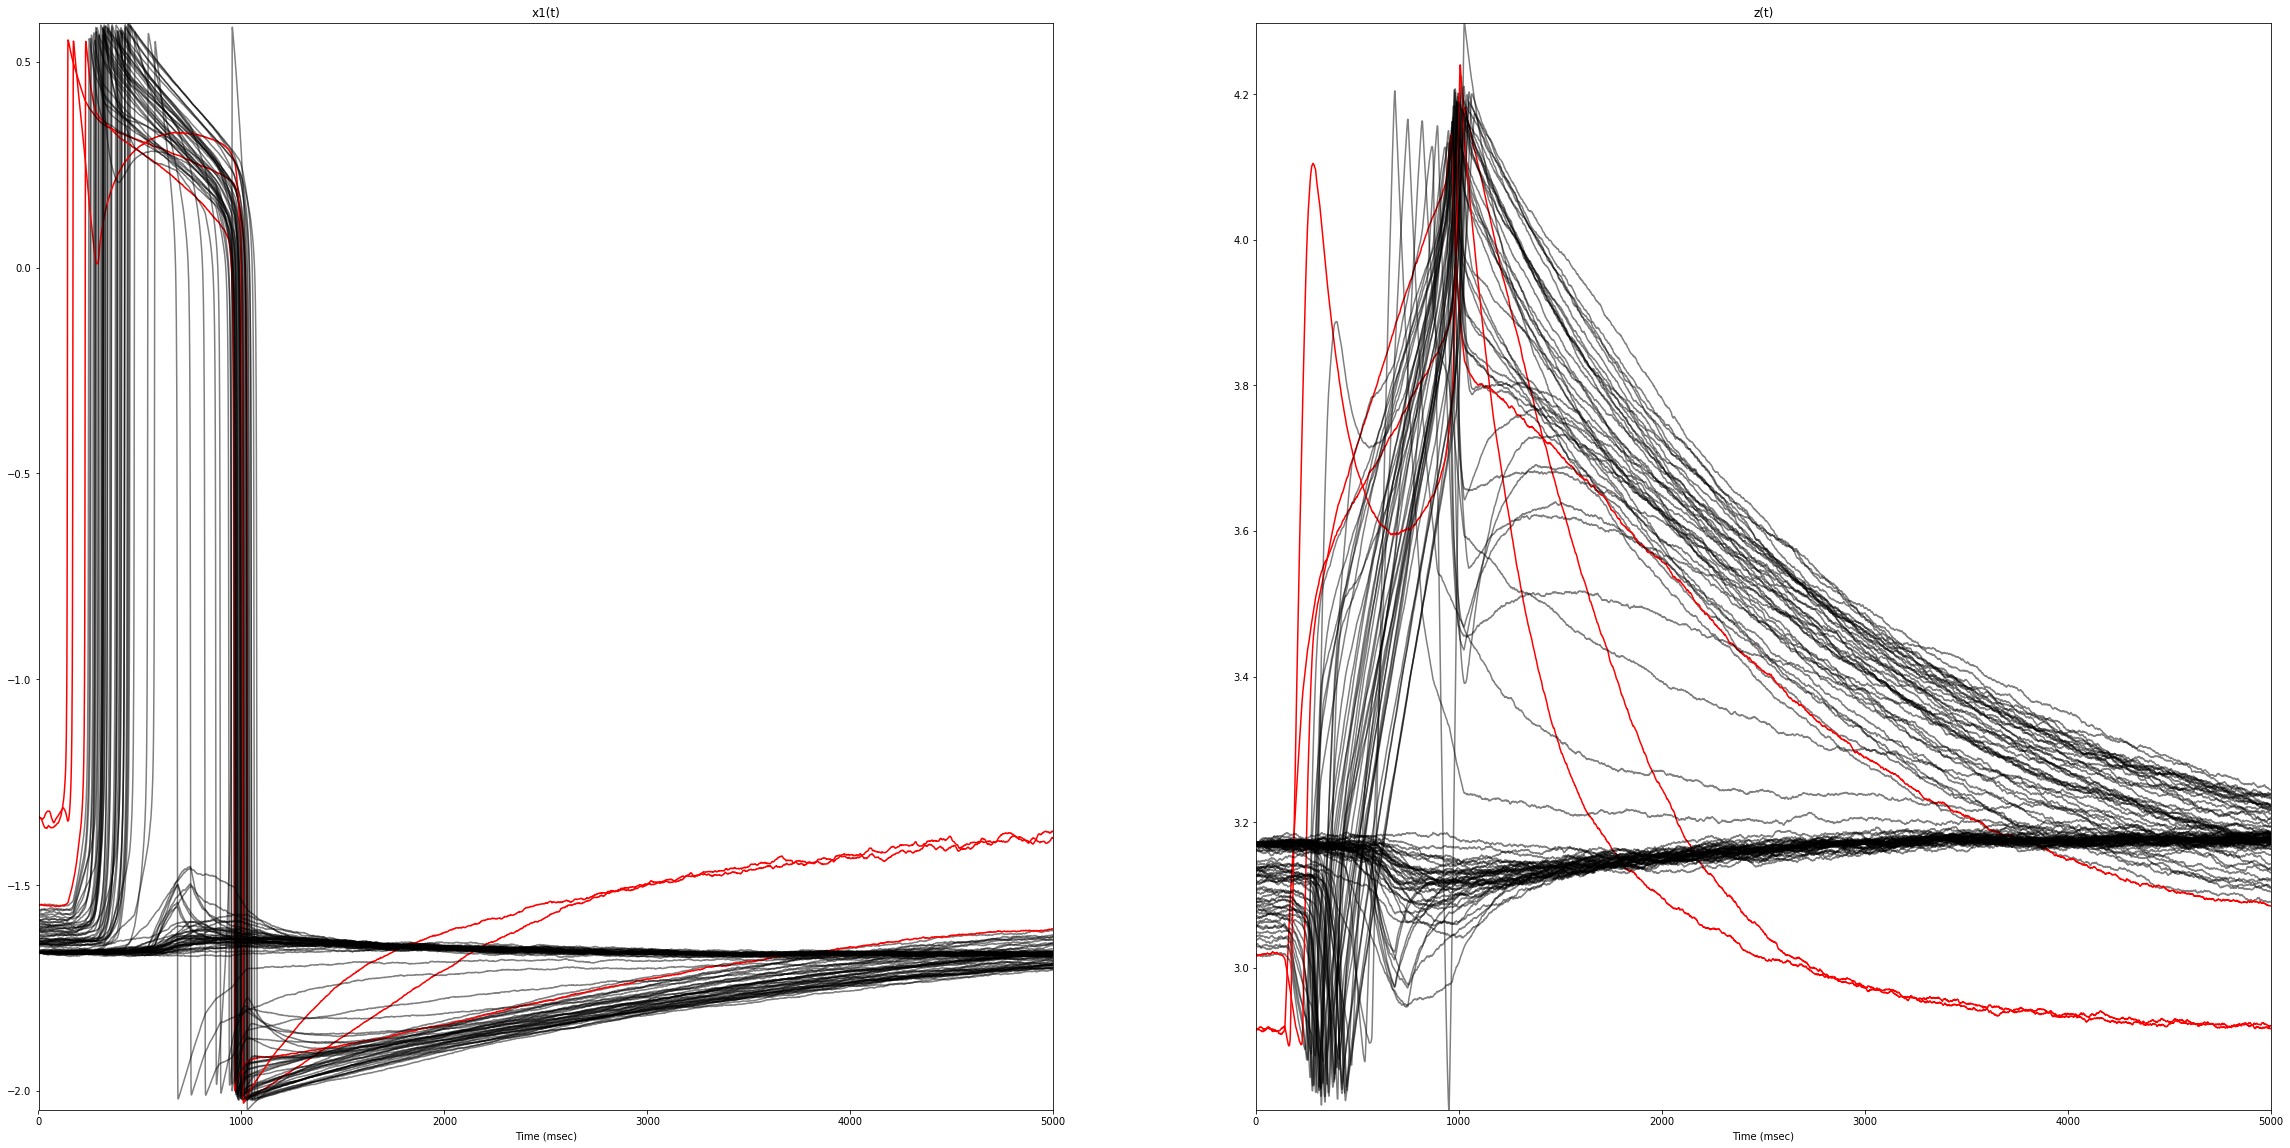

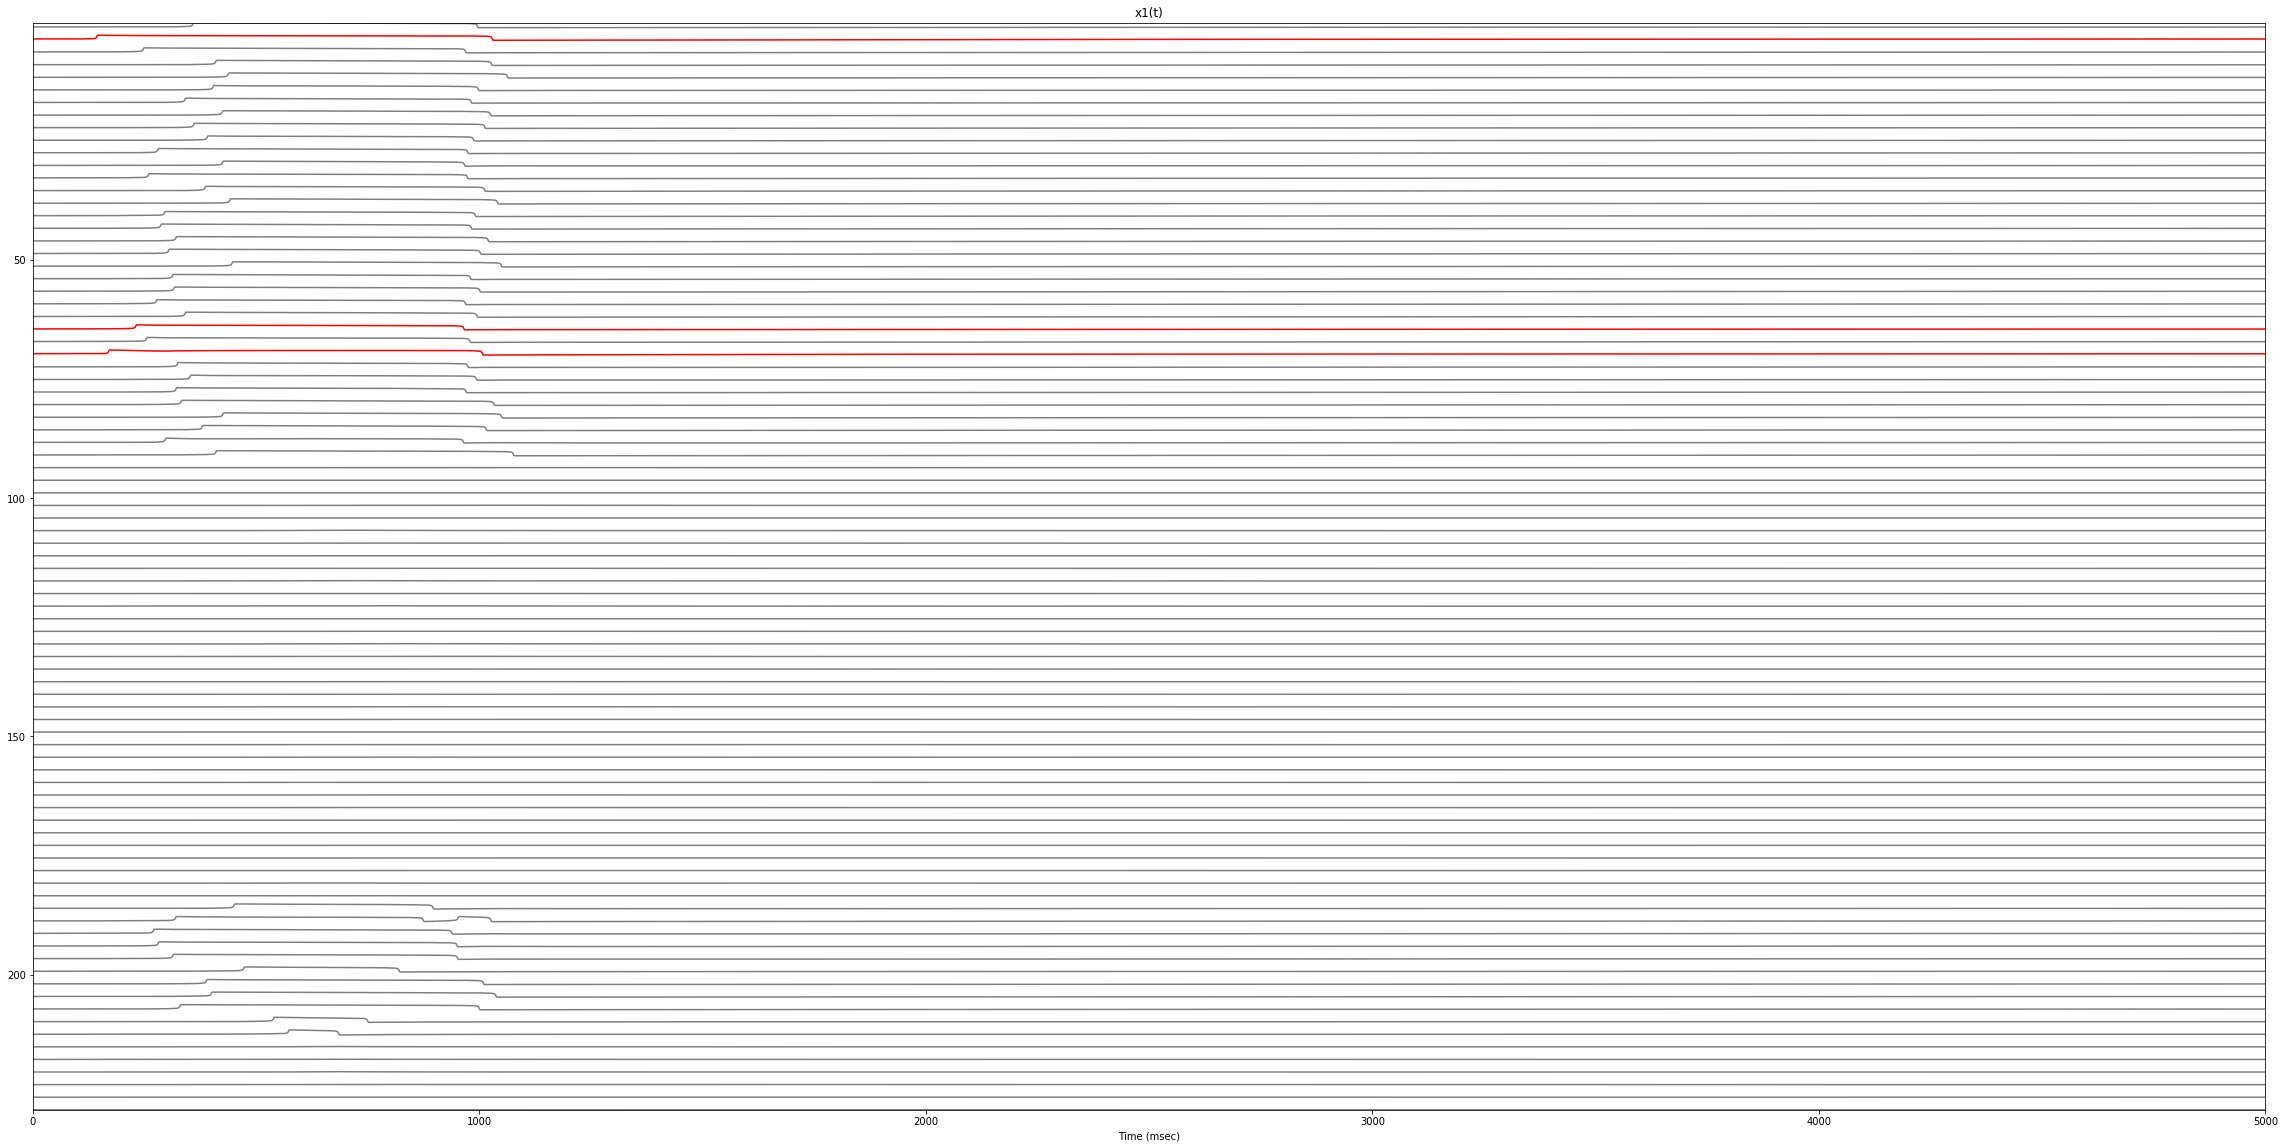

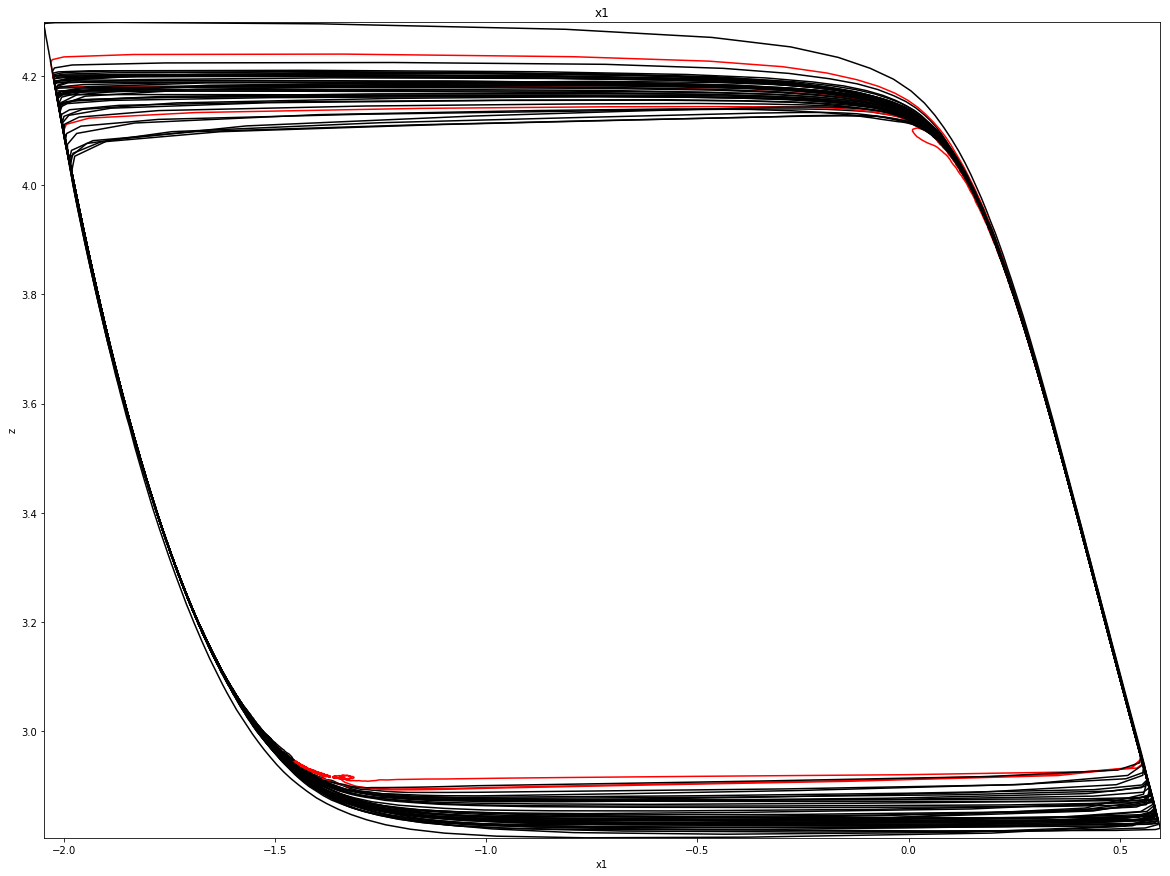

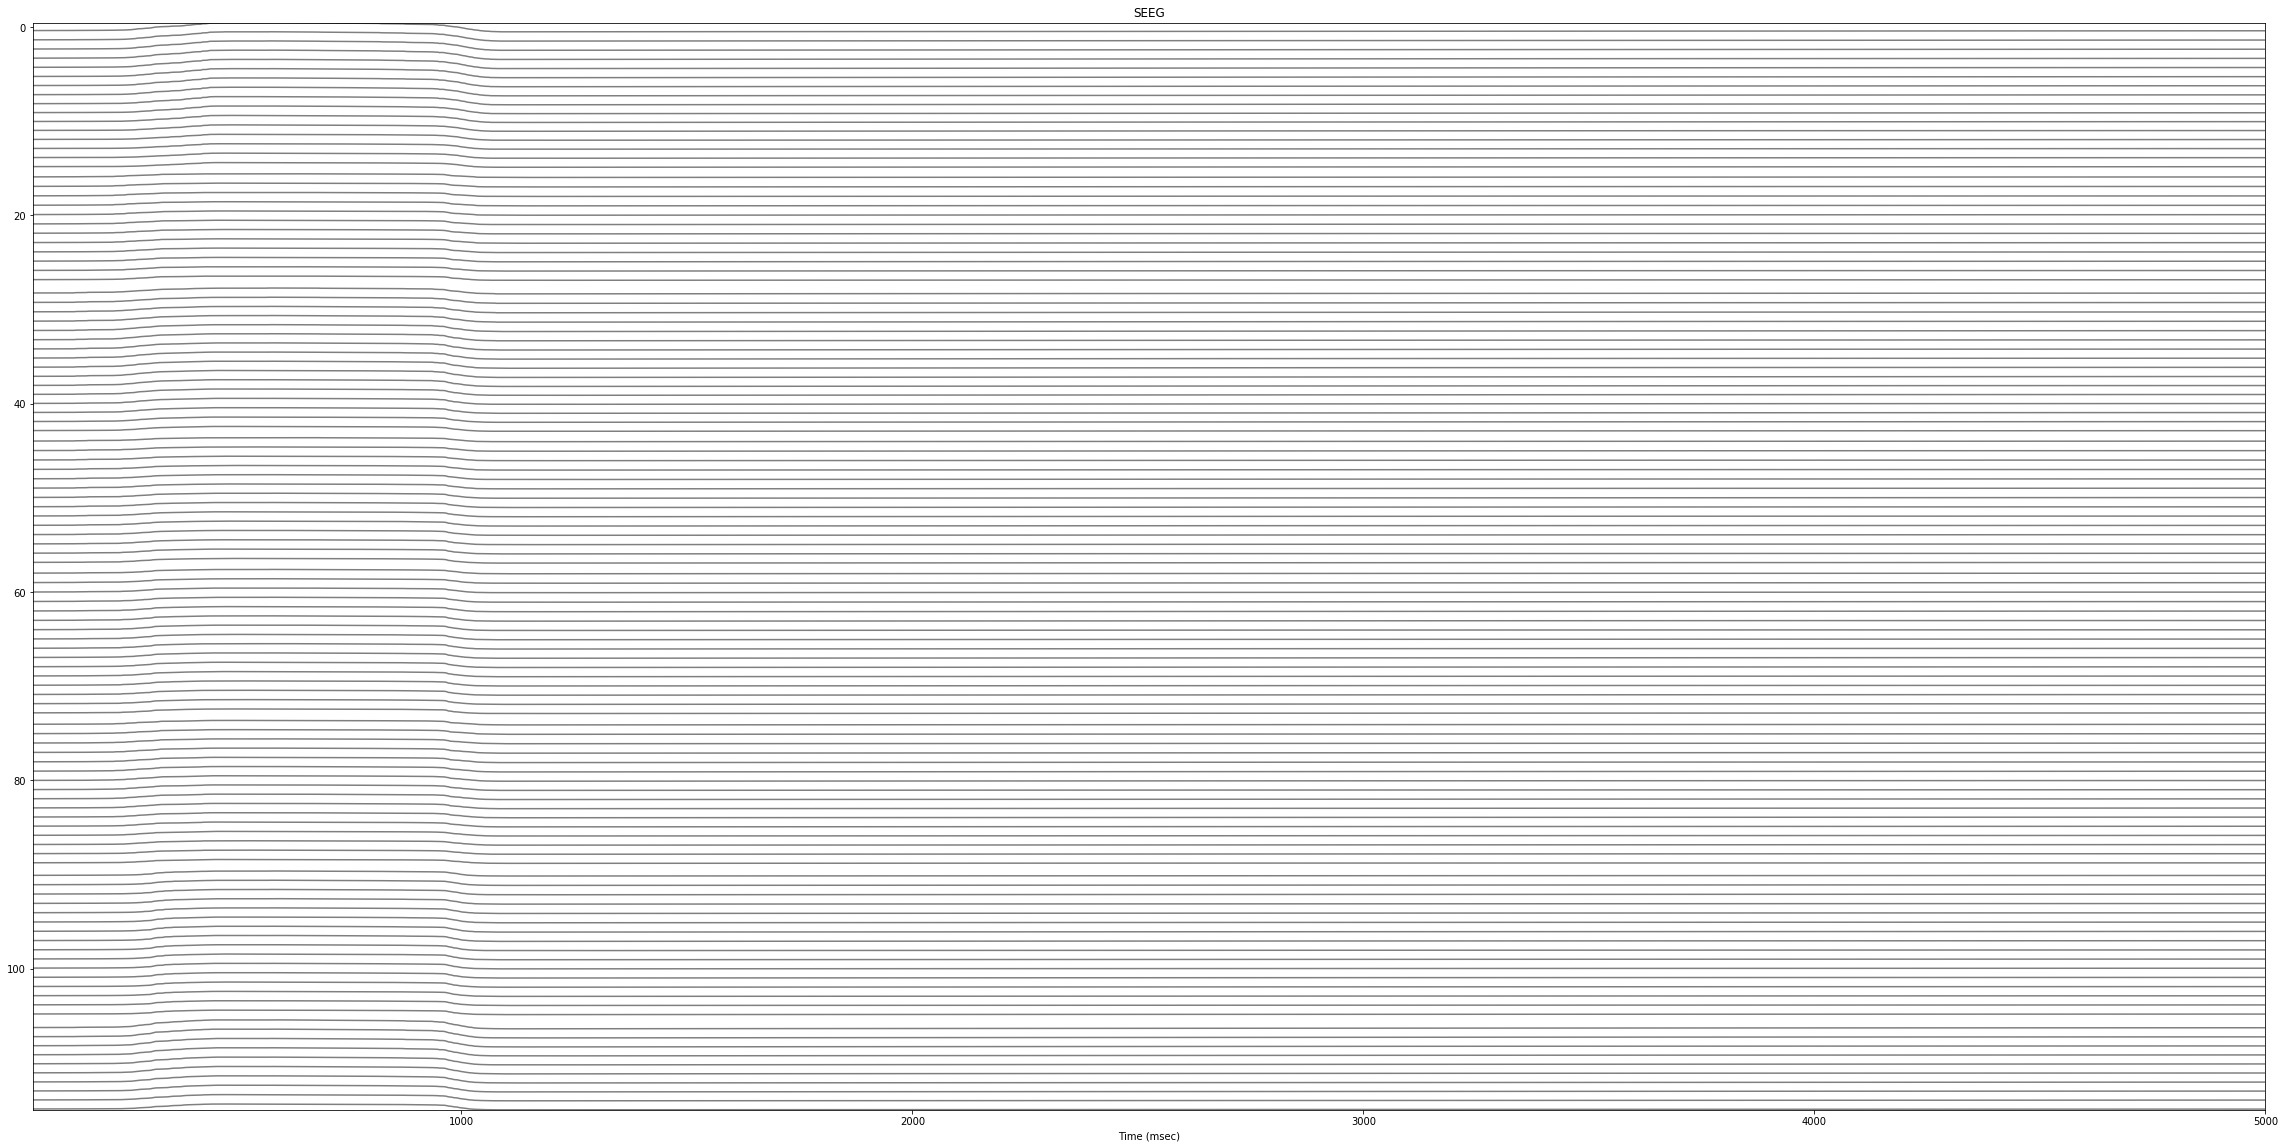

In [25]:
from tvb_epilepsy.service.simulator_builder import SimulatorBuilder
from tvb_epilepsy.top.scripts.simulation_scripts import prepare_vois_ts_dict, compute_seeg_and_write_ts_h5_file

# --------------------------Simulation-----------------------------------
sim_type = "fitting" #"tvb" # "fitting"
logger.info("\n\nConfiguring simulation from model_configuration...")
# If you choose model...
# Available models beyond the TVB Epileptor (they all encompass optional variations from the different papers):
# EpileptorDP: similar to the TVB Epileptor + optional variations,
# EpileptorDP2D: reduced 2D model, following Proix et all 2014 +optional variations,
# EpleptorDPrealistic: starting from the TVB Epileptor + optional variations, but:
#      -x0, Iext1, Iext2, slope and K become noisy state variables,
#      -Iext2 and |slope are coupled to z, g, or z*g in order for spikes to appear before seizure,
#      -multiplicative correlated noise is also used
# We don't want any time delays for the moment
head.connectivity.tract_lengths *= 0.0
sim_builder = SimulatorBuilder(config.simulator.MODE)
# First set model name, then build settings!
if sim_type == "realistic":
    model = sim_builder.set_model_name("EpileptorDPrealistic").generate_model(model_configuration)
    model.tau0 = 30000.0
    model.tau1 = 0.2
    model.slope = 0.25
    sim_settings = sim_builder.set_simulated_period(50000).build_sim_settings()
    sim_settings.noise_type = COLORED_NOISE
    sim_settings.noise_ntau = 10
elif sim_type == "fitting":
    model = sim_builder.set_model_name("EpileptorDP2D").generate_model(model_configuration)
    model.tau0 = 2857.0
    model.tau1 = 0.5
    sim_settings = sim_builder.set_fs(4096.0).set_simulated_period(5000).build_sim_settings()
    sim_settings.noise_intensity = [0.0, 1e-7]
elif sim_type == "reduced":
    model = sim_builder.set_model_name("EpileptorDP2D").generate_model(model_configuration)
    model.tau0 = 2857.0
    model.tau1 = 0.5
    sim_settings = sim_builder.set_fs(4096.0).set_simulated_period(5000).build_sim_settings()
    sim_settings.noise_intensity = [0.0, 1e-7]
elif sim_type == "tvb":
   model = sim_builder.set_model_name("Epileptor").generate_model(model_configuration)
   sim_settings = sim_builder.set_simulated_period(5000).build_sim_settings()
else:
   model = sim_builder.generate_model(model_configuration)
   sim_settings = sim_builder.build_sim_settings()  # "EpileptorDP" by default

# sim_settings.noise_intensity *= 0.001 
print("noise_intesity=", sim_settings.noise_intensity)
sim, sim_settings, model = sim_builder.build_simulator_TVB_from_model_sim_settings(model_configuration, 
                                                                                   head.connectivity, model, sim_settings)

sim_path = os.path.join(config.out.FOLDER_RES, lsa_hypothesis.name + "_sim_settings.h5")
writer.write_simulation_settings(sim.simulation_settings, sim_path)
writer.write_generic(sim.model, config.out.FOLDER_RES, lsa_hypothesis.name + "_sim_model.h5")

# Integrator and initial conditions initialization.
# By default initial condition is set right on the equilibrium point.
logger.info("\n\nSimulating...")
ttavg, tavg_data, status = sim.launch_simulation(report_every_n_monitor_steps=100)

if not status:
    logger.warning("\nSimulation failed!")
else:
    time = np.array(ttavg, dtype='float32')
    output_sampling_time = np.mean(np.diff(time))
    tavg_data = tavg_data[:, :, :, 0]
    logger.info("\n\nSimulated signal return shape: %s", tavg_data.shape)
    logger.info("Time: %s - %s", time[0], time[-1])
    logger.info("Values: %s - %s", tavg_data.min(), tavg_data.max())
    # Variables of interest in a dictionary:
    res_ts = prepare_vois_ts_dict(sim_settings.monitor_expressions, tavg_data)
    res_ts['time'] = time
    res_ts['time_units'] = 'msec'
    # A script to compute lfp, seeg and save results to a file:
    res_ts = compute_seeg_and_write_ts_h5_file(config.out.FOLDER_RES, lsa_hypothesis.name + "_ts.h5",
                                               sim.model, res_ts, output_sampling_time,
                                               sim_settings.simulated_period,
                                               hpf_flag=True, hpf_low=10.0, hpf_high=512.0,
                                               sensors_list=head.sensorsSEEG)
    # Plot results
    if model._ui_name is "EpileptorDP2D":
        spectral_raster_plot = False
        trajectories_plot = True
    else:
        spectral_raster_plot = False # "lfp"
        trajectories_plot = False
    plotter.plot_sim_results(sim.model, lsa_hypothesis.lsa_propagation_indices, res_ts,
                                 head.sensorsSEEG, hpf_flag=True, trajectories_plot=trajectories_plot,
                                 spectral_raster_plot=spectral_raster_plot, log_scale=True)
   # Optionally save results in mat file...
   # from scipy.io import savemat
   # savemat(os.path.join(config.out.FOLDER_RES, lsa_hypothesis.name + "_ts.mat"), res_ts)
   # ...or in .npy file:
   # np.save(os.path.join(config.out.FOLDER_RES, lsa_hypothesis.name + "_ts.npy"), res_ts)